# Intelligent Document Data Extraction and Analytics Agent
**Capstone Project for 5-Day Gen AI Intensive Course with Google**

## Business Problem
In some industries such as financial services, a significant amount of historical data remains locked in unstructured formats like PDFs. These documents often contain a mix of text, images, and tables. Unlocking this data can provide organizations with richer analytical insights. Once extracted, the data can be queried using natural language through Retrieval-Augmented Generation (RAG). By integrating the extracted data with an agent capable of generating and executing Python code, the system can perform advanced analyses on the structured data, delivering deeper, more actionable insights. 

The project aims to address the challenges of efficiently retrieving both unstructured (text) and structured (tables) information from PDF files, and leveraging GenAI capabilities to gain deeper insights from the extracted data.

## Proposed Solution
We proposed a two-part solution composed of a data extraction component and a data querying engine. First, we develop an intelligent system for data extraction from PDF documents using Gemini document-understanding ability. The extracted data is then analysed using prompting  and enhanced by an agent capable of executing Python code on tabular data for advanced analysis and processing.

### Data Extaction
The figure belows show the data extraction and storage into a vector and JSON databases. Since we are intersted in exploring the multi-modal LLMs, we will use Gemini 2.0 Flash for document understanding and data extraction with prompting. Another alternative not explored here is to use [Langchain PDF Loaders](https://python.langchain.com/docs/integrations/document_loaders/#pdfs).

Both the text and tables are extracted with two different prompts. For the table extraction, we require Gemini output to be structured in JSON format. The text is stored in a ChromaDB vector database and the tables are stored in a JSON database.


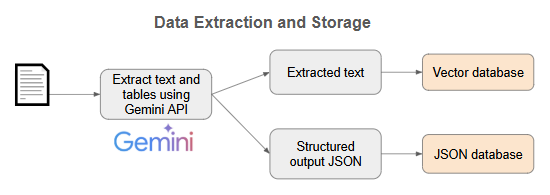

### Data Querying
The second part of the project shows develops querying capabilities using RAG and an analytics agent capable of executing python code. The user can submit general natural language queries or prompts which communicate with the vector storage using RAG. Additionally, users can enter data science or analytics related queries based on the tabular data in JSON format. For the latter, we make use of the [Code execution capabilities](https://ai.google.dev/gemini-api/docs/code-execution?lang=python) of Gemini.

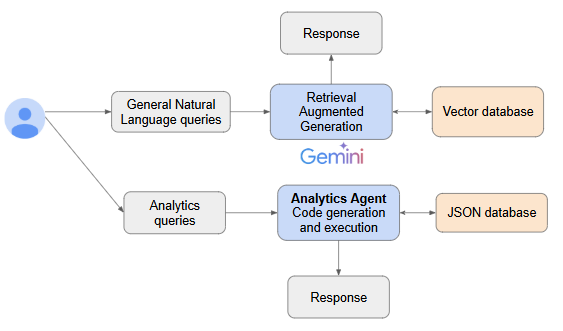

# Environment Configuration and Dependencies

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy jupyterlab jupyterlab-lsp kfp

# Install langgraph and the packages used in this lab.
# !pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install -U -q "google-genai==1.7.0"  "chromadb==0.6.3"
!pip install langchain langchain-community

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/documents/PC_Insurers_Filings.pdf
/kaggle/input/documents/Principal-Sample-Life-Insurance-Policy.pdf
/kaggle/input/documents/Travelers-2024-Annual-Report.pdf
/kaggle/input/documents/Shelter_HO-4Renters.pdf
/kaggle/input/documents/allstate_filing.pdf


In [4]:
# Import libraries
import os
from kaggle_secrets import UserSecretsClient
from google import genai
from google.genai import types

from typing import Annotated
from typing_extensions import TypedDict

# from langgraph.graph.message import add_messages
import pathlib
import httpx

import json
import pandas as pd

from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry


print(genai.__version__)

1.7.0


In [5]:
# Setting up Google API key

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [6]:
# Automated Retry
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [7]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [8]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
mod

# Data Extraction from Documents

This section extracts text and tables from PDF documents using Gemini API. Gemini models can process large PDFs with native vision. I am using the document understanding secion of [Google docs](https://ai.google.dev/gemini-api/docs/document-processing?lang=python)

Future enhancements:
- Current completion is getting truncated because it exceeds the max output tokens. Consider extracting information by page.

In [ ]:
folder = pathlib.Path("/kaggle/input/documents/")
files = [f for f in folder.iterdir() if f.is_file()]
filepath = pathlib.Path("/kaggle/input/documents/Shelter_HO-4Renters.pdf")

In [ ]:
prompt_data_extraction = "Extract all the data of this PDF extactly as is, by preserving all original information."
def extract_data_from_pdf(filepath):
    prompt = prompt_data_extraction
    response = client.models.generate_content(
      model="gemini-2.0-flash",
        config =     types.GenerateContentConfig(
            temperature=0,
            max_output_tokens = 10**6
        ),
      contents=[
          types.Part.from_bytes(
            data=filepath.read_bytes(),
            mime_type='application/pdf',
          ),
          prompt])
    return response

In [ ]:
# response = client.models.generate_content(
#     model="gemini-2.0-flash",
#     contents="Explain AI to me like I'm a kid.")

response = extract_data_from_pdf(filepath)
print(response.text)

In [ ]:
out = {}
for filepath in files:
    out[filepath.name.split('.')[0]] = extract_data_from_pdf(filepath)

In [ ]:
def extract_data_from_pdf_table(filepath):
    prompt_data_extraction = "Extract the first 5 tables of this PDF. Return response in JSON format."
    prompt = prompt_data_extraction
    response = client.models.generate_content(
      model="gemini-2.0-flash",
        config =  types.GenerateContentConfig(
            # temperature=0,
            # max_output_tokens = 10**9,
            response_mime_type="application/json"
        ),
      contents=[
          types.Part.from_bytes(
            data=filepath.read_bytes(),
            mime_type='application/pdf',
          ),
          prompt])
    return response

In [ ]:
filepath = pathlib.Path("/kaggle/input/documents/Travelers-2024-Annual-Report.pdf")
response = extract_data_from_pdf_table(filepath)

In [ ]:
print(response.text)

In [ ]:
json.loads(response.text)[0]

# Data Storage

## Vector Databases

In [ ]:



# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

In [ ]:
out.keys()

In [ ]:
[el.text for el in out.values()]

In [ ]:
import chromadb

DB_NAME = "googlecardb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=[el.text for el in out.values()], ids=list(out.keys()))

In [ ]:
db.count()


# Querying Data

## Natural Languange

In [ ]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "What is the definition of land motor vehicle?"

result = db.query(query_texts=[query], n_results=1)
[all_passages] = result["documents"]

Markdown(all_passages[0])

In [ ]:
query_oneline = query.replace("\n", " ")

# This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
prompt = f"""What is the definition of land motor vehicle?

QUESTION: {query_oneline}
"""

# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", " ")
    prompt += f"PASSAGE: {passage_oneline}\n"

# print(prompt)
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)

Markdown(answer.text)

## Code execution

In [ ]:
df = pd.DataFrame(json.loads(response.text)[0]['content'])

In [ ]:
from IPython.display import HTML, Markdown, display, Image

def display_code_execution_result(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    if part.executable_code is not None:
      code_html = f'<pre style="background-color: #BBBBEE;">{part.executable_code.code}</pre>' # Change code color
      display(HTML(code_html))
    if part.code_execution_result is not None:
      display(Markdown(part.code_execution_result.output))
    if part.inline_data is not None:
      display(Image(data=part.inline_data.data, format="png"))
    display(Markdown("---"))

In [ ]:
    rc = client.models.generate_content(
      model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
      tools=[types.Tool(
        code_execution=types.ToolCodeExecution
      )]),
      contents=[
          json.dumps(json.loads(response.text)[0]),
          "Generate a bar plot with matplotlib respresenting the percetage of total by location"])

In [ ]:
display_code_execution_result(rc)

In [ ]:
rc

In [ ]:
import base64
image_bytes = base64.b64decode(rc.candidates[0].content.parts[2].code_execution_result.output)
display(Image(data=image_bytes))